In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature
import xarray as xr
import pandas as pd
import cProfile
import netCDF4 as nc
import numpy as np
import itertools
import sys
import toolbox as tb
import cftime
import SCM5

In [2]:
def cycle_lon(dataarray):
    dataslice = xr.DataArray(dataarray.isel(lon=0))
    dataslice = dataslice.assign_coords(lon=360)
    return xr.concat([dataarray,dataslice],dim='lon')

In [81]:
def sort_lon(dataarray, longitude, latitude):
    return_ds = dataarray.to_dataset().copy()
    return_ds['lon']=longitude
    return_ds['lat']=latitude
    return_ds = xr.concat([return_ds.isel(y=j).sortby('lon') for j in range(len(dataarray.y))], dim='y')
    return return_ds

In [57]:
def rmean(data, n):
    return pd.Series(data).rolling(window=n, min_periods=1, center=True).mean().values

In [58]:
data_folder = "/projects/NS4659K/chuncheng/cases_fram/NBF1850_f19_tn11_test_mis3b_fwf3b_fram"

In [59]:
grid = xr.open_dataset('/nird/home/yro/data/grid_mis3.nc')
grid

<xarray.Dataset>
Dimensions:  (pcomp: 77925, qcomp: 79271, ucomp: 79539, vcomp: 78882, y: 385,
              x: 360, nv: 4)
Coordinates:
  * pcomp    (pcomp) int32 7871 7872 7873 7874 ... 138539 138540 138541 138542
  * qcomp    (qcomp) int32 7872 7873 7874 7875 ... 138540 138541 138542 138543
  * ucomp    (ucomp) int32 7871 7872 7873 7874 ... 138540 138541 138542 138543
  * vcomp    (vcomp) int32 7871 7872 7873 7874 ... 138539 138540 138541 138542
Dimensions without coordinates: y, x, nv
Data variables: (12/53)
    insw     (y, x) int32 ...
    jnsw     (y, x) int32 ...
    ins      (y, x) int32 ...
    jns      (y, x) int32 ...
    inse     (y, x) int32 ...
    jnse     (y, x) int32 ...
    ...       ...
    vdepth   (y, x) float64 ...
    pmask    (y, x) int32 ...
    umask    (y, x) int32 ...
    vmask    (y, x) int32 ...
    qmask    (y, x) int32 ...
    cplmask  (y, x) int32 ...
Attributes:
    nreg:     2

## Data

In [60]:
# SAT

# proxy: ?

sat = xr.open_dataset("/nird/home/yro/temp/mis3.t2m.am.nc")
sat

<xarray.Dataset>
Dimensions:    (time: 9588, lat: 96, lon: 144, nbnd: 2)
Coordinates:
  * time       (time) object 1701-02-01 00:00:00 ... 2500-01-01 00:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object ...
    TS         (time, lat, lon) float32 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             NBF1850_f19_tn11_test_mis3b_fwf3b_fram
    title:            UNSET
    logname:          cgu025
    host:             c68-6
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami_0...
    topography_file:  /cluster/shared/noresm/inputdata/atm/cam/topo/bnd_topo_...
    history:          Mon Jan 16 16:18:18 2023: ncrcat -O --no_tmp_fl /nird/h...
    NCO:              netCDF Operators version 4.8.1 (Homepage = http://nco.s...

In [4]:
# Sea Ice

# proxy: https://doi.pangaea.de/10.1594/PANGAEA.894970

fice = xr.open_dataset("/nird/home/yro/temp/mis3.fice.om.nc")
fice

<xarray.Dataset>
Dimensions:  (time: 9588, y: 385, x: 360)
Coordinates:
  * time     (time) object 1701-01-17 00:00:00 ... 2499-12-17 00:00:00
Dimensions without coordinates: y, x
Data variables:
    fice     (time, y, x) float32 ...
Attributes:
    history:  Tue Jan 17 12:38:21 2023: ncrcat -O --no_tmp_fl /nird/home/yro/...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

In [61]:
# Ice Fraction

# proxy: https://doi.pangaea.de/10.1594/PANGAEA.894970

icefrac = xr.open_dataset("/nird/home/yro/temp/mis3.icefrac.am.nc")
icefrac

<xarray.Dataset>
Dimensions:    (time: 9588, lat: 96, lon: 144, nbnd: 2)
Coordinates:
  * time       (time) object 1701-02-01 00:00:00 ... 2500-01-01 00:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object ...
    ICEFRAC    (time, lat, lon) float32 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             NBF1850_f19_tn11_test_mis3b_fwf3b_fram
    title:            UNSET
    logname:          cgu025
    host:             c68-6
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami_0...
    topography_file:  /cluster/shared/noresm/inputdata/atm/cam/topo/bnd_topo_...
    history:          Mon Jan 16 17:23:32 2023: ncrcat -O --no_tmp_fl /nird/h...
    NCO:              netCDF Operators version 4.8.1 (Homepage = http://nco.s...

In [62]:
# Ocean temperature

# proxy: https://doi.pangaea.de/10.1594/PANGAEA.894970

ocnT = xr.open_dataset("/nird/home/yro/temp/mis3.ocnt.oy.nc")
ocnT

<xarray.Dataset>
Dimensions:     (time: 799, depth: 70, bounds: 2, y: 385, x: 360)
Coordinates:
  * time        (time) object 1701-07-02 12:00:00 ... 2499-07-02 12:00:00
  * depth       (depth) float64 0.0 5.0 10.0 15.0 ... 6.25e+03 6.5e+03 6.75e+03
Dimensions without coordinates: bounds, y, x
Data variables:
    depth_bnds  (depth, bounds) float64 ...
    templvl     (time, depth, y, x) float32 ...
Attributes:
    history:  Tue Jan 17 17:23:45 2023: ncrcat -O --no_tmp_fl /nird/home/yro/...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

In [63]:
# AMOC

# proxy : ?

amoc = xr.open_dataset("/nird/home/yro/temp/mis3.amoc.oy.nc").isel(region=0, drop=True)
amoc

<xarray.Dataset>
Dimensions:     (time: 799, depth: 70, bounds: 2, lat: 166)
Coordinates:
  * time        (time) object 1701-07-02 12:00:00 ... 2499-07-02 12:00:00
  * depth       (depth) float64 0.0 5.0 10.0 15.0 ... 6.25e+03 6.5e+03 6.75e+03
  * lat         (lat) float64 -80.0 -79.0 -78.0 -77.0 ... 82.0 83.0 84.0 85.0
Dimensions without coordinates: bounds
Data variables:
    depth_bnds  (depth, bounds) float64 ...
    mmflxd      (time, depth, lat) float64 ...
Attributes:
    history:  Mon Jan 16 19:08:34 2023: ncrcat -O --no_tmp_fl /nird/home/yro/...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

In [64]:
# MLD

# proxy : https://doi.pangaea.de/10.1594/PANGAEA.894970

mld = xr.open_dataset("/nird/home/yro/temp/mis3.mld.om.nc")
mld

<xarray.Dataset>
Dimensions:  (time: 9588, y: 385, x: 360)
Coordinates:
  * time     (time) object 1701-01-17 00:00:00 ... 2499-12-17 00:00:00
Dimensions without coordinates: y, x
Data variables:
    maxmld   (time, y, x) float32 ...
Attributes:
    history:  Tue Jan 17 11:59:37 2023: ncrcat -O --no_tmp_fl /nird/home/yro/...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

In [65]:
# SST

sst = xr.open_dataset("/nird/home/yro/temp/mis3.sst.om.nc")
sst

<xarray.Dataset>
Dimensions:  (time: 9588, y: 385, x: 360)
Coordinates:
  * time     (time) object 1701-01-17 00:00:00 ... 2499-12-17 00:00:00
Dimensions without coordinates: y, x
Data variables:
    sst      (time, y, x) float32 ...
Attributes:
    history:  Tue Jan 17 14:45:04 2023: ncrcat -O --no_tmp_fl /nird/home/yro/...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

## Figure 1 - Summary

In [75]:
amoc_ts = tb.kgs_to_sv(amoc.mmflxd.sel(lat=26.).max(dim='depth'))
sat_ts = sat.TS.sel(lon=322.5).isel(lat=87).groupby("time.year").mean()-273.15
ice_cover = (fice.fice.groupby("time.year").mean()*grid.parea).sum(dim='x').sum(dim='y')

In [76]:
stadial = (2100,2200)
interstadial = (2350,2450)
dtime = lambda yr : cftime.DatetimeNoLeap(yr,1,1)

In [77]:
sat_map = {}
sat_map['stadial']=cycle_lon(sat.TS.sel(time=slice(dtime(stadial[0]),dtime(stadial[1]))).mean(dim='time')) - 273.15
sat_map['interstadial']=cycle_lon(sat.TS.sel(time=slice(dtime(interstadial[0]),dtime(interstadial[1]))).mean(dim='time')) - 273.15

sst_map = {}
sst_map['stadial']=sst.sst.sel(time=slice(dtime(stadial[0]),dtime(stadial[1]))).mean(dim='time')
sst_map['interstadial']=sst.sst.sel(time=slice(dtime(interstadial[0]),dtime(interstadial[1]))).mean(dim='time')

In [82]:
wice = {}
wice['stadial'] = sort_lon(fice.fice.sel(time=icefrac.time.dt.month.isin([3])).sel(time=slice(dtime(stadial[0]),dtime(stadial[1]))).groupby("time.year").mean().mean(dim='year'),
                           grid.ulon, grid.ulat)
wice['interstadial'] = sort_lon(fice.fice.sel(time=icefrac.time.dt.month.isin([3])).sel(time=slice(dtime(interstadial[0]),dtime(interstadial[1]))).groupby("time.year").mean().mean(dim='year'),
                           grid.ulon, grid.ulat)

sice = {}
sice['stadial'] = sort_lon(fice.fice.sel(time=icefrac.time.dt.month.isin([9])).sel(time=slice(dtime(stadial[0]),dtime(stadial[1]))).groupby("time.year").mean().mean(dim='year'),
                           grid.ulon, grid.ulat)
sice['interstadial'] = sort_lon(fice.fice.sel(time=icefrac.time.dt.month.isin([9])).sel(time=slice(dtime(interstadial[0]),dtime(interstadial[1]))).groupby("time.year").mean().mean(dim='year'),
                           grid.ulon, grid.ulat)

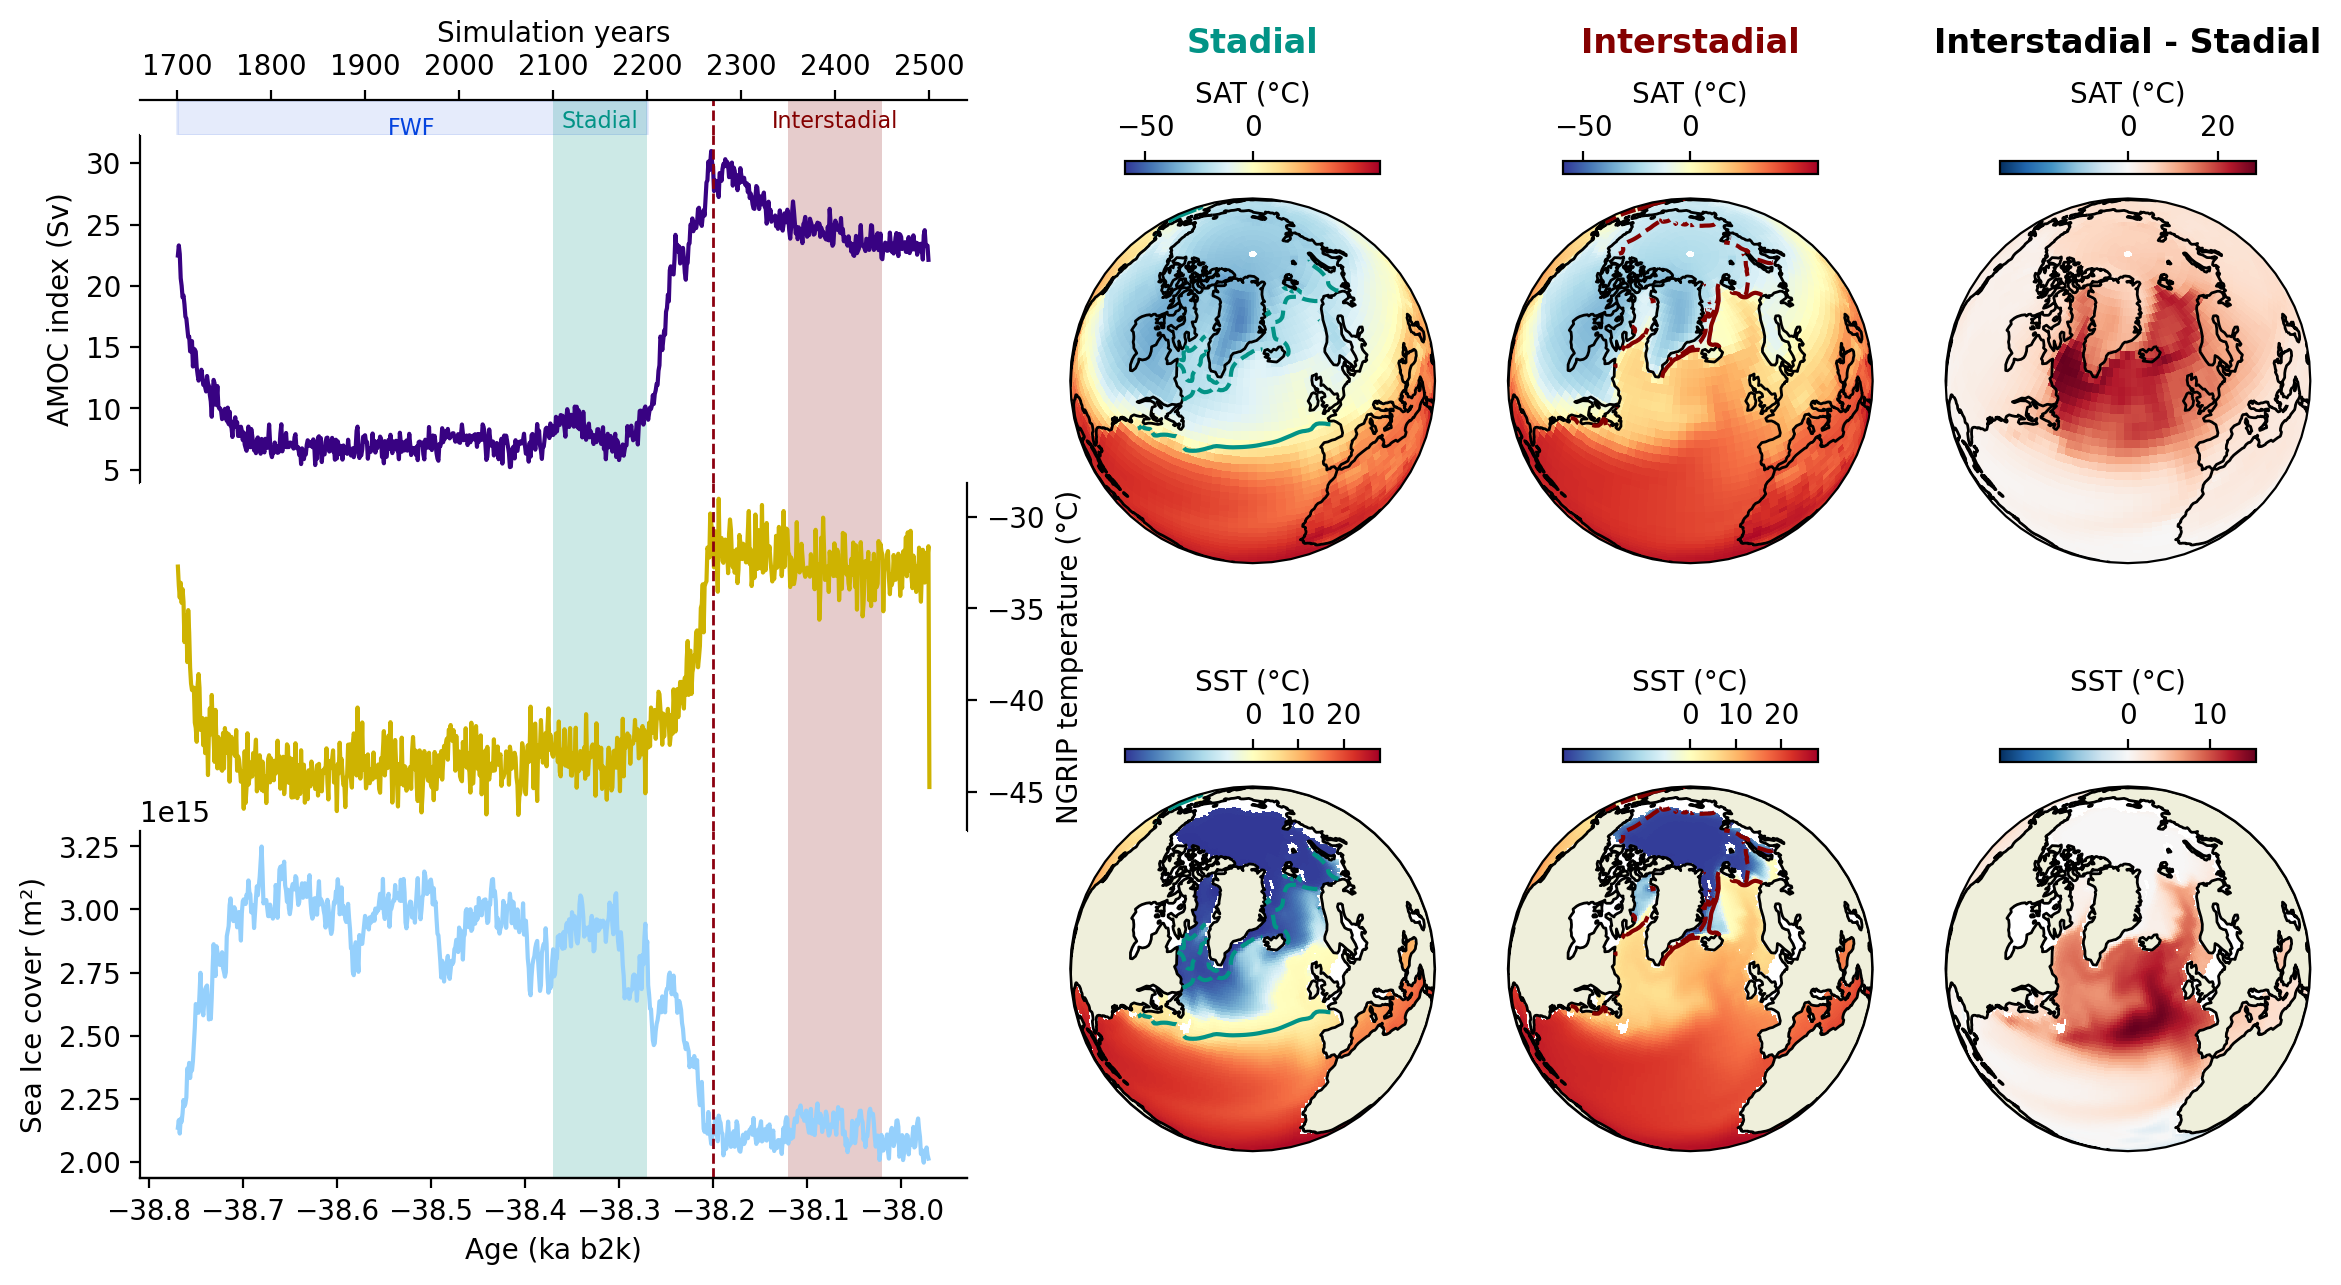

In [84]:
fig = plt.figure(figsize=(14,7), dpi=200)

pannel = fig.add_gridspec(1, 2, width_ratios=[2,3], wspace=0.1)
pannel_ts = gridspec.GridSpecFromSubplotSpec(4, 1, hspace=0, height_ratios=[1,10,10,10], subplot_spec=pannel[0,0])
pannel_map = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=pannel[0,1])

# Create the axes
axTs = {}
axTs['AMOC'] = fig.add_subplot(pannel_ts[1,0])
axTs['Notes'] = fig.add_subplot(pannel_ts[0,0], sharex=axTs['AMOC'])
axTs['NGRIP'] = fig.add_subplot(pannel_ts[2,0], sharex=axTs['AMOC'])
axTs['sea ice'] = fig.add_subplot(pannel_ts[3,0], sharex=axTs['AMOC'])

projection_map = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=60, satellite_height=10000000)

axSAT = {}
axSAT['stadial'] = fig.add_subplot(pannel_map[0,0], projection=projection_map)
axSAT['interstadial'] = fig.add_subplot(pannel_map[0,1], projection=projection_map)
axSAT['anomaly'] = fig.add_subplot(pannel_map[0,2], projection=projection_map)

axSST = {}
axSST['stadial'] = fig.add_subplot(pannel_map[1,0], projection=projection_map)
axSST['interstadial'] = fig.add_subplot(pannel_map[1,1], projection=projection_map)
axSST['anomaly'] = fig.add_subplot(pannel_map[1,2], projection=projection_map)


# Plot the time series
axTs['AMOC'].plot(amoc_ts.time.dt.year, amoc_ts, color='xkcd:indigo')
axTs['NGRIP'].plot(sat_ts.year, sat_ts, color='xkcd:mustard')
axTs['sea ice'].plot(ice_cover.year, ice_cover, color='xkcd:light blue')


# Norms 

norm = {}
norm['sat'] = mpl.colors.TwoSlopeNorm(vmin=np.nanmin([sat_map['interstadial'], sat_map['stadial']]),
                               vcenter=0,
                               vmax=np.nanmax([sat_map['interstadial'], sat_map['stadial']]))
norm['satan'] = mpl.colors.TwoSlopeNorm(vmin=np.nanmin(sat_map['interstadial'] - sat_map['stadial']),
                               vcenter=0,
                               vmax=np.nanmax(sat_map['interstadial'] - sat_map['stadial']))
norm['sst'] = mpl.colors.TwoSlopeNorm(vmin=np.nanmin([sst_map['interstadial'], sst_map['stadial']]),
                               vcenter=0,
                               vmax=np.nanmax([sst_map['interstadial'], sst_map['stadial']]))
norm['sstan'] = mpl.colors.TwoSlopeNorm(vmin=np.nanmin(sst_map['interstadial'] - sst_map['stadial']),
                               vcenter=0,
                               vmax=np.nanmax(sst_map['interstadial'] - sst_map['stadial']))


# Plot the maps
cmap = {}

cmap['satst'] = axSAT['stadial'].pcolormesh(sat_map['stadial'].lon, sat_map['stadial'].lat, sat_map['stadial'], 
                                            norm=norm['sat'], cmap='RdYlBu_r', transform=ccrs.PlateCarree())
cmap['satit'] = axSAT['interstadial'].pcolormesh(sat_map['stadial'].lon, sat_map['stadial'].lat, sat_map['interstadial'], 
                                                 norm=norm['sat'], cmap='RdYlBu_r', transform=ccrs.PlateCarree())
cmap['satan'] = axSAT['anomaly'].pcolormesh(sat_map['stadial'].lon, sat_map['stadial'].lat,
                                            sat_map['interstadial'] - sat_map['stadial'], 
                                            norm=norm['satan'], cmap='RdBu_r', transform=ccrs.PlateCarree())

cmap['sstst'] = axSST['stadial'].pcolormesh(grid.ulon, grid.ulat, sst_map['stadial'],
                                            norm=norm['sst'], cmap='RdYlBu_r', transform=ccrs.PlateCarree())
cmap['sstit'] = axSST['interstadial'].pcolormesh(grid.ulon, grid.ulat, sst_map['interstadial'],
                                                 norm=norm['sst'], cmap='RdYlBu_r', transform=ccrs.PlateCarree())
cmap['sstan'] = axSST['anomaly'].pcolormesh(grid.ulon, grid.ulat, sst_map['interstadial'] - sst_map['stadial'],
                                            norm=norm['sstan'], cmap='RdBu_r', transform=ccrs.PlateCarree())


# Sea ice

for ax in axSAT, axSST:
    ax['stadial'].contour(wice['stadial'].lon, wice['stadial'].lat, wice['stadial'].fice, 
                             levels=[50], colors='xkcd:teal', transform=ccrs.PlateCarree())
    ax['stadial'].contour(sice['stadial'].lon, sice['stadial'].lat, sice['stadial'].fice, 
                             levels=[50], colors='xkcd:teal', linestyles='--', transform=ccrs.PlateCarree())
    ax['interstadial'].contour(wice['interstadial'].lon, wice['interstadial'].lat, wice['interstadial'].fice, 
                         levels=[50], colors='xkcd:dark red', transform=ccrs.PlateCarree())
    ax['interstadial'].contour(sice['interstadial'].lon, sice['interstadial'].lat, sice['interstadial'].fice, 
                         levels=[50], colors='xkcd:dark red', linestyles='--', transform=ccrs.PlateCarree())


# Colorbars
fig.colorbar(cmap['satst'], ax=axSAT['stadial'], location='top', shrink=0.7, label="SAT (°C)")
fig.colorbar(cmap['satit'], ax=axSAT['interstadial'], location='top', shrink=0.7, label="SAT (°C)")
fig.colorbar(cmap['satan'], ax=axSAT['anomaly'], location='top', shrink=0.7, label="SAT (°C)")
fig.colorbar(cmap['sstst'], ax=axSST['stadial'], location='top', shrink=0.7, label="SST (°C)")
fig.colorbar(cmap['sstit'], ax=axSST['interstadial'], location='top', shrink=0.7, label="SST (°C)")
fig.colorbar(cmap['sstan'], ax=axSST['anomaly'], location='top', shrink=0.7, label="SST (°C)")


# Spans and annotations
for ax in axTs.values():
    ax.axvspan(stadial[0], stadial[1], alpha=0.2, linewidth=0, color='xkcd:teal')
    ax.axvspan(interstadial[0], interstadial[1], alpha=0.2, linewidth=0, color='xkcd:dark red')
    ax.axvline(2270, color="xkcd:crimson", linestyle="--", linewidth=1)
axTs['Notes'].annotate('Stadial', xy=((stadial[0]+stadial[1])/2, 0.2), xycoords='data', size=8, ha='center', color='xkcd:teal')
axTs['Notes'].annotate('Interstadial', xy=((interstadial[0]+interstadial[1])/2, 0.2), xycoords='data', size=8, ha='center', color='xkcd:dark red')


rec = Rectangle((1700, 0), 500, 1, fill=True, alpha=0.1, zorder=0, color='xkcd:blue',)
axTs['Notes'].add_patch(rec)
axTs['Notes'].annotate('FWF', (1950, 0.2),
                      color='xkcd:blue', fontsize=8, ha='center', va='center')

axSAT['stadial'].annotate('Stadial', xy=(0.5, 1.4), xycoords='axes fraction',
                          weight='bold', size=12, ha='center', color='xkcd:teal')
axSAT['interstadial'].annotate('Interstadial', xy=(0.5, 1.4), xycoords='axes fraction',
                          weight='bold', size=12, ha='center', color='xkcd:dark red')
axSAT['anomaly'].annotate('Interstadial - Stadial', xy=(0.5, 1.4), xycoords='axes fraction',
                          weight='bold', size=12, ha='center', color='black')

# Time series parameters
for loc in ['left','right','bottom'] : axTs['Notes'].spines[loc].set_visible(False)
axTs['Notes'].xaxis.set_ticks_position('top')
axTs['Notes'].xaxis.set_label_position('top')
axTs['Notes'].set_xlabel("Simulation years")
axTs['Notes'].yaxis.set_visible(False)

for loc in ['right','top','bottom'] : axTs['AMOC'].spines[loc].set_visible(False)
axTs['AMOC'].xaxis.set_visible(False)
axTs['AMOC'].set_ylabel("AMOC index (Sv)")

for loc in ['left','top','bottom'] : axTs['NGRIP'].spines[loc].set_visible(False)
axTs['NGRIP'].yaxis.set_ticks_position('right')
axTs['NGRIP'].yaxis.set_label_position('right')
axTs['NGRIP'].set_ylabel("NGRIP temperature (°C)")
axTs['NGRIP'].xaxis.set_visible(False)

for loc in ['right','top'] : axTs['sea ice'].spines[loc].set_visible(False)
axTs['sea ice'].secondary_xaxis('bottom', functions=(lambda a : a/1000 -40.47 , lambda a : a*1000 + 40.47)).set_xlabel("Age (ka b2k)")
# CHECK TIME!!!
axTs['sea ice'].xaxis.set_visible(False)
axTs['sea ice'].set_ylabel("Sea Ice cover (m²)")


# Map parameters
for ax in [*axSST.values(),*axSAT.values()]:ax.set_global()
for ax in axSAT.values():ax.coastlines()
for ax in axSST.values():ax.add_feature(cartopy.feature.LAND, edgecolor='black', zorder=1)

## Figure 3 - Time series

In [73]:
x_proxy, y_proxy = tb.lonlat_index(grid.ulon.values, grid.ulat.values, -1, 62.4)

In [74]:
amoc_ts = tb.kgs_to_sv(amoc.mmflxd.sel(lat=26.).max(dim='depth'))
sat_ts = sat.TS.sel(lon=322.5).isel(lat=87).groupby("time.year").mean()-273.15
wice_ts = fice.fice.sel(time=fice.time.dt.month.isin([3])).groupby("time.year").mean().isel(y=mld.y[mld.y == y_proxy].values[0]).isel(x=mld.x[mld.x == x_proxy].values[0])
t100 = ocnT.templvl.isel(y=mld.y[mld.y == y_proxy].values[0]).isel(x=mld.x[mld.x == x_proxy].values[0]).sel(depth=100.)
mld_ts = mld.maxmld.isel(y=mld.y[mld.y == y_proxy].values[0]).isel(x=mld.x[mld.x == x_proxy].values[0]).groupby("time.year").mean()


In [75]:
proxy = {}
proxy['isotopes'] = pd.read_csv(f'/nird/home/yro/data/Sadatzki_etal_2018/datasets/MD99-2284_d13C_d18O_ARM_SST.tab',
                            sep='\t', skiprows=21, header=0, 
                            names=["depth", "age", "ARM",'SST','pachydermaO18','pachydermaC13','neoteretisO18','neoteretisC13'])
proxy['biomarkers'] = pd.read_csv(f'/nird/home/yro/data/Sadatzki_etal_2018/datasets/MD99-2284_biomarkers.tab',
                            sep='\t', skiprows=29, header=0, usecols=[0,1,18],
                            names=["depth", "age", "PDIP25"])

proxy['biomarkers']

,depth,age,PDIP25
0,20.305,31.775,0.500
1,20.405,31.841,0.716
2,20.505,31.908,0.641
3,20.605,31.974,0.705
4,20.705,32.040,0.831
...,...,...,...
143,32.455,40.067,0.409
144,32.555,40.089,0.371
145,32.655,40.112,0.488
146,32.755,40.135,0.283


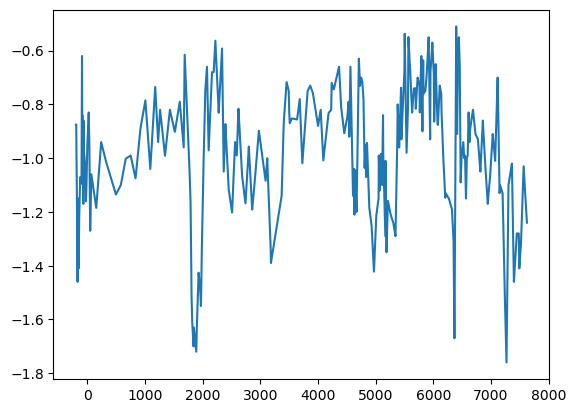

In [76]:
plt.plot(-proxy['isotopes'].age*1000+40000, proxy['isotopes'].neoteretisC13.interpolate())

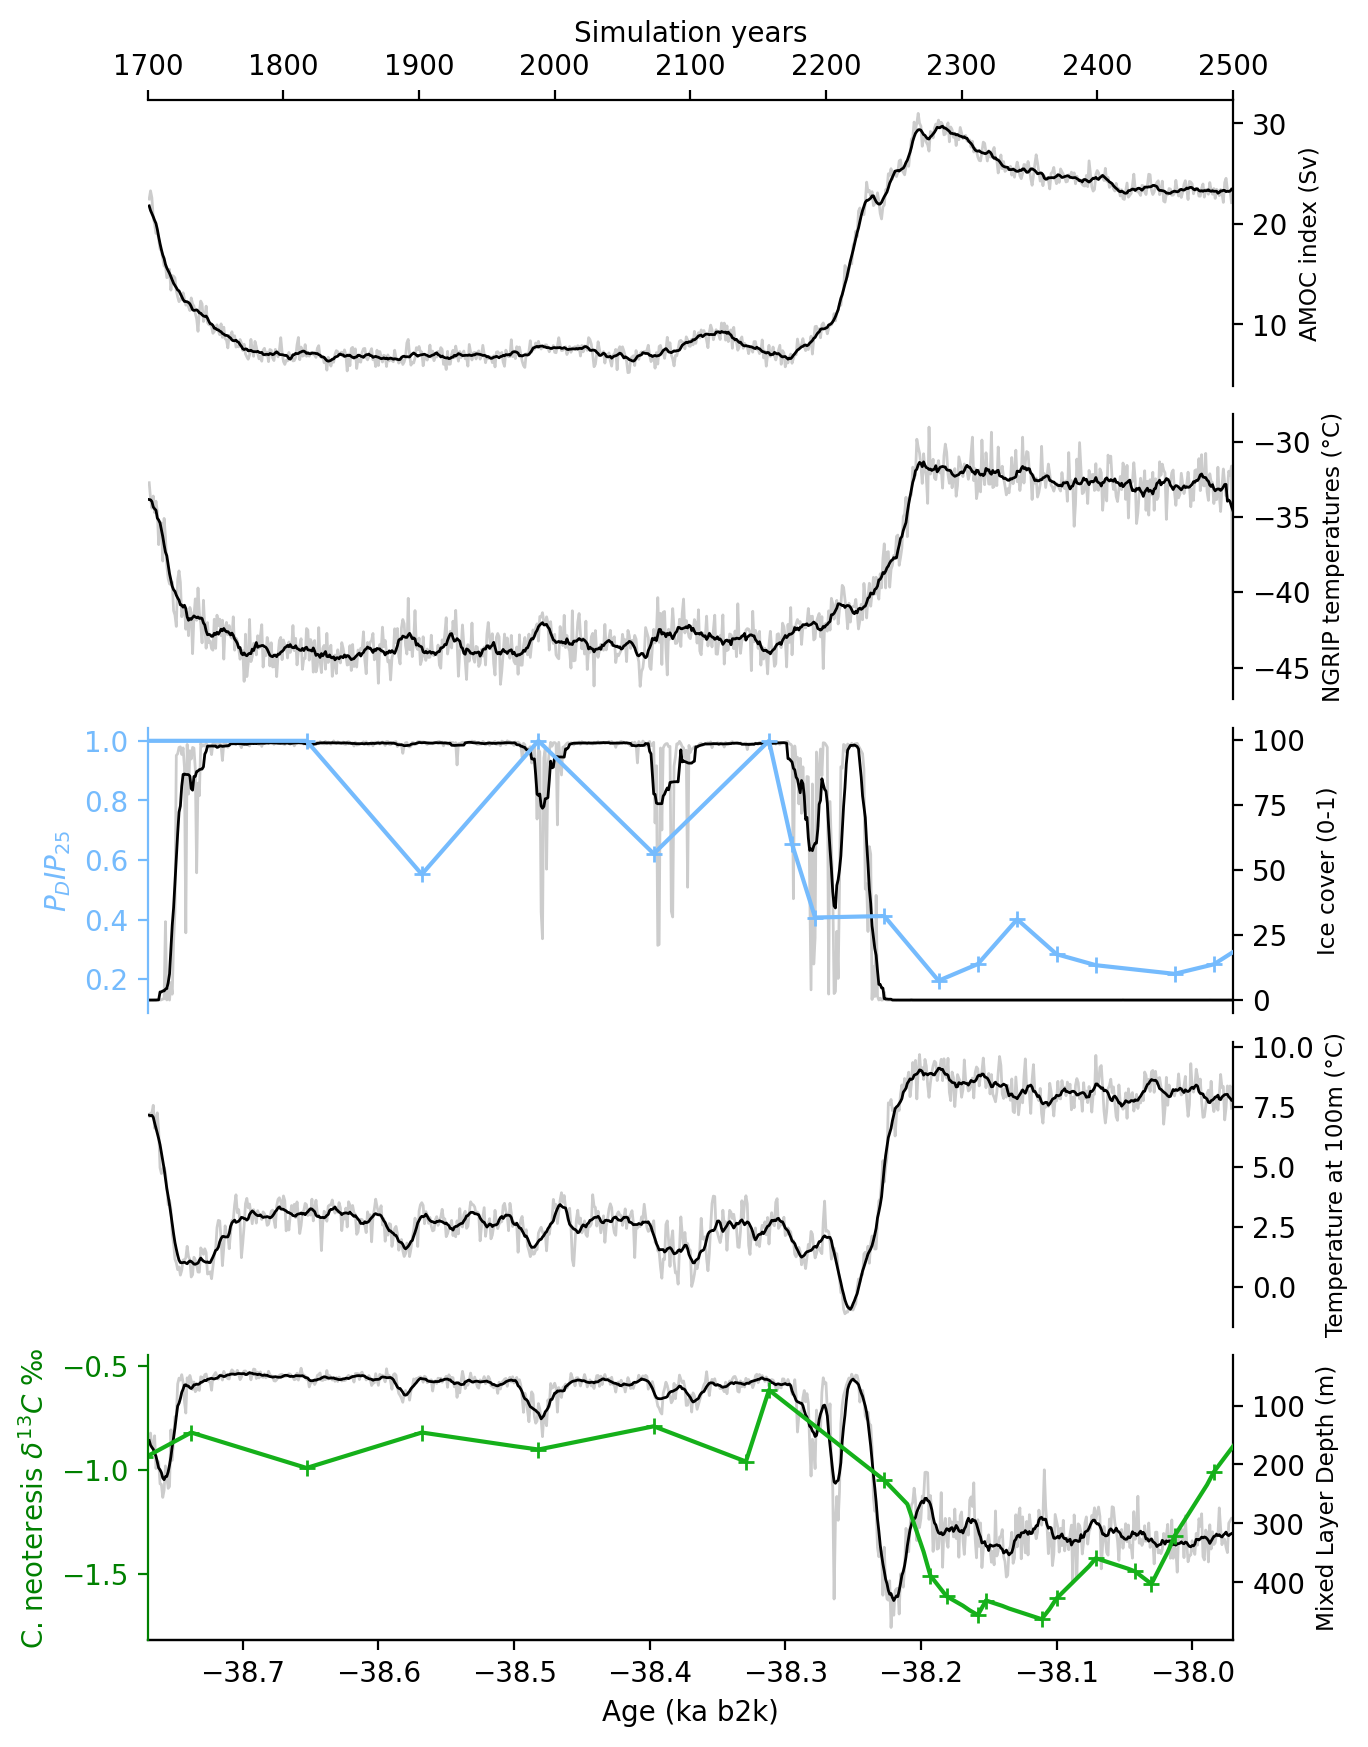

In [85]:
fig = plt.figure(figsize=(7,10), dpi=200)

axTs, axProxy = {}, {}
axTs['AMOC'] = fig.add_subplot(5, 1, 1, facecolor='None')
axTs['NGRIP'] = fig.add_subplot(5, 1, 2, sharex=axTs['AMOC'], facecolor='None')
axTs['ice cover'] = fig.add_subplot(5, 1, 3, sharex=axTs['AMOC'], facecolor='None')
axProxy['ice cover'] = axTs['ice cover'].twinx()
axTs['T100'] = fig.add_subplot(5, 1, 4, sharex=axTs['AMOC'], facecolor='None')
axTs['MLD'] = fig.add_subplot(5, 1, 5, sharex=axTs['AMOC'], facecolor='None')
axProxy['MLD'] = axTs['MLD'].twinx()

fig.subplots_adjust(hspace=0.1)

# Plot the time series
axTs['AMOC'].plot(amoc_ts.time.dt.year, rmean(amoc_ts,10), color='xkcd:black', linewidth=1)
axTs['AMOC'].plot(amoc_ts.time.dt.year, amoc_ts, color='xkcd:black', linewidth=1, alpha=0.2)
axTs['NGRIP'].plot(sat_ts.year, rmean(sat_ts,10), color='xkcd:black', linewidth=1)
axTs['NGRIP'].plot(sat_ts.year, sat_ts, color='xkcd:black', linewidth=1, alpha=0.2)
axTs['ice cover'].plot(wice_ts.year, rmean(wice_ts,10), color='xkcd:black', linewidth=1)
axTs['ice cover'].plot(wice_ts.year, wice_ts, color='xkcd:black', linewidth=1, alpha=0.2)
axTs['T100'].plot(t100.time.dt.year, rmean(t100,10), color='xkcd:black', linewidth=1)
axTs['T100'].plot(t100.time.dt.year, t100, color='xkcd:black', linewidth=1, alpha=0.2)
axTs['MLD'].plot(mld_ts.year, rmean(mld_ts,10), color='xkcd:black', linewidth=1)
axTs['MLD'].plot(mld_ts.year, mld_ts, color='xkcd:black', linewidth=1, alpha=0.2)


# Plot the proxies
age_to_syr = lambda x : (40.47-x)*1000
axProxy['ice cover'].plot(age_to_syr(proxy['biomarkers'].age), proxy['biomarkers'].PDIP25.interpolate(),
                          color='xkcd:sky blue')
axProxy['ice cover'].plot(age_to_syr(proxy['biomarkers'].age), proxy['biomarkers'].PDIP25,
                          color='xkcd:sky blue', linewidth=0, marker='+')
axProxy['MLD'].plot(age_to_syr(proxy['isotopes'].age), proxy['isotopes'].neoteretisC13.interpolate(), 
                    color='xkcd:green')
axProxy['MLD'].plot(age_to_syr(proxy['isotopes'].age), proxy['isotopes'].neoteretisC13, 
                    color='xkcd:green', linewidth=0, marker='+')

# Spans
# To define over the figure or shrink the plotting region
# for ax in axTs.values() : 
#     ax.axvspan(1700, 2200, ymin=-0.05, ymax=1.5, alpha=0.2, linewidth=0, color='xkcd:sky blue')
#     ax.axvline(2270, color="xkcd:crimson", linestyle="--", linewidth=1)


# Time series parameters
for ax in axTs.values() : ax.yaxis.set_ticks_position('right')
for ax in axTs.values() : ax.yaxis.set_label_position('right')
for ax in axTs.values() : ax.spines['left'].set_visible(False)
for plot in ['NGRIP', 'ice cover', 'T100', 'MLD'] : axTs[plot].spines['top'].set_visible(False)
for plot in ['AMOC', 'NGRIP', 'ice cover', 'T100'] : axTs[plot].spines['bottom'].set_visible(False)
for plot in ['NGRIP', 'ice cover', 'T100', 'MLD'] : axTs[plot].xaxis.set_visible(False)

axTs['AMOC'].xaxis.set_ticks_position('top')
axTs['AMOC'].xaxis.set_label_position('top')
axTs['AMOC'].set_xlabel("Simulation years")
axTs['AMOC'].set_ylabel("AMOC index (Sv)", size='small')

axTs['NGRIP'].set_ylabel("NGRIP temperatures (°C)", size='small')

axTs['ice cover'].set_ylabel("Ice cover (0-1)", size='small')

axTs['T100'].set_ylabel("Temperature at 100m (°C)", size='small')

axTs['MLD'].set_ylabel("Mixed Layer Depth (m)", size='small')
axTs['MLD'].invert_yaxis()
axTs['MLD'].secondary_xaxis('bottom', functions=(lambda a : a/1000 -40.47 , lambda a : a*1000 + 40.47)).set_xlabel("Age (ka b2k)")


# Proxies parameters
for ax in axProxy.values() : ax.xaxis.set_visible(False)
for ax in axProxy.values() : ax.set_xlim([1700,2500])
for ax in axProxy.values() : ax.yaxis.set_ticks_position('left')
for ax in axProxy.values() : ax.yaxis.set_label_position('left')
for ax in axProxy.values() : ax.spines['right'].set_visible(False)
for ax in axProxy.values() : ax.spines['top'].set_visible(False)
for ax in axProxy.values() : ax.spines['bottom'].set_visible(False)

axProxy['ice cover'].set_ylabel('$P_{D}IP_{25}$', color='xkcd:sky blue')
axProxy['ice cover'].spines['left'].set_color('xkcd:sky blue')
axProxy['ice cover'].tick_params(axis='y', colors='xkcd:sky blue')    

axProxy['MLD'].set_ylabel('C. neoteresis $\delta^{13}C$ ‰', color='green')
axProxy['MLD'].spines['left'].set_color('green')
axProxy['MLD'].tick_params(axis='y', colors='green')